In [1]:
#Les import
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import animation

import scipy.interpolate as sp
import random as rn
import numpy as np
from numpy.random import choice as np_choice

In [2]:
#Déclaration de la classe Ant colony
class AntColony(object):

    def __init__(self, distances, n_ants, n_best, n_iterations, decay, alpha=1, beta=1):
        """
        Args:
            distances (2D numpy.array): Square matrix of distances. Diagonal is assumed to be np.inf.
            n_ants (int): Number of ants running per iteration
            n_best (int): Number of best ants who deposit pheromone
            n_iteration (int): Number of iterations
            decay (float): Rate it which pheromone decays. The pheromone value is multiplied by decay, so 0.95 will lead to decay, 0.5 to much faster decay.
            alpha (int or float): exponenet on pheromone, higher alpha gives pheromone more weight. Default=1
            beta (int or float): exponent on distance, higher beta give distance more weight. Default=1

        Example:
            ant_colony = AntColony(german_distances, 100, 20, 2000, 0.95, alpha=1, beta=2)          
        """
        self.distances  = distances
        self.pheromone = np.ones(self.distances.shape) / len(distances)
        self.all_inds = range(len(distances))
        self.n_ants = n_ants
        self.n_best = n_best
        self.n_iterations = n_iterations
        self.decay = decay
        self.alpha = alpha
        self.beta = beta

    def run(self):
        shortest_path = None
        all_time_shortest_path = ("placeholder", np.inf)
        for i in range(self.n_iterations):
            all_paths = self.gen_all_paths()
            self.spread_pheronome(all_paths, self.n_best, shortest_path=shortest_path)
            shortest_path = min(all_paths, key=lambda x: x[1])
            #print (shortest_path)
            if shortest_path[1] < all_time_shortest_path[1]:
                all_time_shortest_path = shortest_path            
            self.pheromone * self.decay            
        return all_time_shortest_path

    def spread_pheronome(self, all_paths, n_best, shortest_path):
        sorted_paths = sorted(all_paths, key=lambda x: x[1])
        for path, dist in sorted_paths[:n_best]:
            for move in path:
                self.pheromone[move] += 1.0 / self.distances[move]

    def gen_path_dist(self, path):
        total_dist = 0
        for ele in path:
            total_dist += self.distances[ele]
        return total_dist

    def gen_all_paths(self):
        all_paths = []
        for i in range(self.n_ants):
            path = self.gen_path(0)
            all_paths.append((path, self.gen_path_dist(path)))
        return all_paths

    def gen_path(self, start):
        path = []
        visited = set()
        visited.add(start)
        prev = start
        for i in range(len(self.distances) - 1):
            move = self.pick_move(self.pheromone[prev], self.distances[prev], visited)
            path.append((prev, move))
            prev = move
            visited.add(move)
        path.append((prev, start)) # going back to where we started    
        return path

    def pick_move(self, pheromone, dist, visited):
        pheromone = np.copy(pheromone)
        pheromone[list(visited)] = 0

        row = pheromone ** self.alpha * (( 1.0 / dist) ** self.beta)

        norm_row = row / row.sum()
        move = np_choice(self.all_inds, 1, p=norm_row)[0]
        return move




In [3]:
#Premier exemple simple
distances = np.array([[np.inf, 2, 2, 5, 7],
                      [2, np.inf, 4, 8, 2],
                      [2, 4, np.inf, 1, 3],
                      [5, 8, 1, np.inf, 2],
                      [7, 2, 3, 2, np.inf]])

ant_colony = AntColony(distances, 10, 2, 100, 0.95, alpha=1, beta=1)
shortest_path = ant_colony.run()
print ("shorted_path: {}".format(shortest_path))

shorted_path: ([(0, 2), (2, 3), (3, 4), (4, 1), (1, 0)], 9.0)


# Problème du voyageur de commerce

In [4]:
## Déclaration des variables
#Les villes
cities = """
Amsterdam Athens    Barcelona Berlin   Bucarest  Budapest Brussels Copenhagen
Dublin    Edinburgh Gibraltar Helsinki Istanbul  Kiev     Lisbon   London
Madrid    Milan     Moscow    Munich   Nantes    Oslo     Paris    Prague
Reykjavik Riga      Rome      Sofia    Stockholm Toulouse Vilnius  Warsaw
"""

cities = cities.split()
#Les distances entre les villes
__file = "temp.npy"
distances_city = np.load(__file)
for i in range(len(distances_city)):
    distances_city[i,i] = np.inf

#Les positions des villes
res = np.array([[-0.0028343 ,  0.00193624],
       [ 0.02408592, -0.02585343],
       [-0.00897912, -0.0193791 ],
       [ 0.00754416,  0.00179419],
       [ 0.0257134 , -0.01256833],
       [ 0.01527667, -0.00783831],
       [-0.00382835, -0.00101698],
       [ 0.00647134,  0.00807388],
       [-0.01570197,  0.00618319],
       [-0.01105894,  0.01044891],
       [-0.02232285, -0.02750983],
       [ 0.01866317,  0.0181626 ],
       [ 0.03113214, -0.01842927],
       [ 0.02906299,  0.00049091],
       [-0.02698596, -0.02109471],
       [-0.00924251,  0.00105269],
       [-0.01811134, -0.01976595],
       [ 0.00182926, -0.0122141 ],
       [ 0.03392031,  0.01326964],
       [ 0.00524756, -0.00697461],
       [-0.0125184 , -0.00702664],
       [ 0.0045908 ,  0.01647617],
       [-0.00691007, -0.00465357],
       [ 0.00894685, -0.00302529],
       [-0.0227144 ,  0.03190754],
       [ 0.01895345,  0.01164758],
       [ 0.00647134, -0.01934432],
       [ 0.02227401, -0.0166067 ],
       [ 0.01201279,  0.0155904 ],
       [-0.00949691, -0.01484433],
       [ 0.0210391 ,  0.00743915],
       [ 0.0168174 ,  0.00182746]])

Pour simplifier, on va réduire un peu les données

In [5]:
n = len(cities)
n1 = 32
cities = cities[:n1]
distances_city = distances_city[:n1,:n1]
res = res[:n1,:]

Maintenant, on va tourner le modèle

In [6]:
ant_colony = AntColony(distances_city, 30, 30, 200, 0.95, alpha=1, beta=1)
shortest_path = ant_colony.run()
print ("shorted_path: {}".format(shortest_path))

shorted_path: ([(0, 6), (6, 22), (22, 20), (20, 29), (29, 2), (2, 16), (16, 10), (10, 14), (14, 15), (15, 8), (8, 9), (9, 24), (24, 21), (21, 28), (28, 11), (11, 25), (25, 30), (30, 31), (31, 13), (13, 18), (18, 12), (12, 1), (1, 27), (27, 4), (4, 5), (5, 26), (26, 17), (17, 19), (19, 23), (23, 3), (3, 7), (7, 0)], 0.33501340995298845)


In [7]:
text_parcours = ""
for i in range(len(distances_city)):
    text_parcours += cities[shortest_path[0][i][0]]+"-"
text_parcours += cities[0]
print("Le plus court chemin est : "+text_parcours)

Le plus court chemin est : Amsterdam-Brussels-Paris-Nantes-Toulouse-Barcelona-Madrid-Gibraltar-Lisbon-London-Dublin-Edinburgh-Reykjavik-Oslo-Stockholm-Helsinki-Riga-Vilnius-Warsaw-Kiev-Moscow-Istanbul-Athens-Sofia-Bucarest-Budapest-Rome-Milan-Munich-Prague-Berlin-Copenhagen-Amsterdam


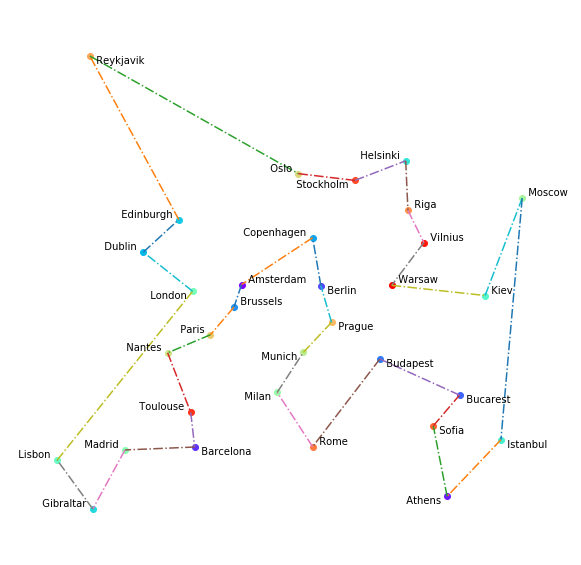

In [8]:
#Affichage
fig = plt.figure(figsize=(10, 10))
ax = fig.gca()
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_axis_off()


# Trimming the final image

bx = min(res[:, 0]), max(res[:, 0])
dx = bx[1] - bx[0]
ax.set_xlim(bx[0] - .1*dx, bx[1] + .1*dx)

by = min(res[:, 1]), max(res[:, 1])
dy = by[1] - by[0]
ax.set_ylim(by[0] - .1*dy, by[1] + .1*dy)

# label placement: subject to automatic optimization!
from collections import defaultdict
d = defaultdict(lambda: {'ha': "left", 'va': "bottom"})

for city in ["Barcelona", "Berlin", "Bucarest", "Budapest",
             "Istanbul", "Prague", "Reykjavik", "Sofia", ]:
    d[city] = {'ha': "left", 'va': "top"}
for city in ["Athens", "London", "Munich",  "Milan",
             "Stockholm", ]:
    d[city] = {'ha': "right", 'va': "top"}
for city in ["Copenhagen", "Dublin", "Edinburgh", "Gibraltar",
             "Helsinki", "Lisbon", "Madrid", "Nantes", "Oslo",
             "Paris", "Toulouse", ]:
    d[city] = {'ha': "right", 'va': "bottom"}
    
# automatic colouring
colors = plt.cm.rainbow(np.linspace(0, 1, n))
    
for i, ((x, y), city, color) in enumerate(zip(res, cities, colors)):
    ax.scatter(x, y, color=color)
    ax.annotate("  " + city + "  ", (x, y), **d[city])
for i in range(n1):
    x_cities = np.array([res[shortest_path[0][i][0]][0], res[shortest_path[0][i][1]][0]])
    y_cities = np.array([res[shortest_path[0][i][0]][1], res[shortest_path[0][i][1]][1]])
    ax.plot(x_cities,y_cities,'-.')